# Train Seq Model


In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from lightgbm import LGBMRegressor, plot_importance
from sklearn.base import clone
from sklearn.metrics import r2_score
import optuna
import joblib
from joblib import Parallel, delayed
import numpy as np
from datetime import datetime
import shap
import gpplot
import matplotlib.pyplot as plt

from datasets import dataset_list
from core import (setup_plots,
                  lollipop_plot,
                  get_feature_df)

In [2]:
setup_plots()

In [3]:
def lgbm_training_iteration(train_df, X, train_index, test_index, base_model):
    """Train lgbm model for optuna iterations

    :param train_df: DataFrame
    :param train_index: list-like
    :param test_index: list-like
    :param base_model: LGBMRegressor
    :return: r^2
    """
    fold_train_df = train_df.iloc[train_index,:].reset_index(drop=True)
    X_train_val = X.iloc[train_index,:].reset_index(drop=True)
    y_train_val = fold_train_df['sgRNA Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.2, random_state=7)
    model = clone(base_model)
    model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=False)
    fold_test_df = train_df.iloc[test_index,:].reset_index(drop=True)
    X_test = X.iloc[test_index,:]
    test_predictions = fold_test_df.copy()
    test_predictions['prediction'] = model.predict(X_test)
    r2 = r2_score(test_predictions['sgRNA Activity'], test_predictions['prediction'])
    return r2


def get_lgbm_objective(train_df, X):
    """Get objective function for training a lgbm model

    :param train_df: DataFrame
    :return: obejctive function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for lgbm

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
        num_leaves = trial.suggest_int('num_leaves', 8, 256)
        min_child_samples = trial.suggest_int('min_child_samples', 8, 256)
        model = LGBMRegressor(random_state=7, n_jobs=1, learning_rate=0.01, n_estimators=5000,
                              num_leaves=num_leaves,
                              min_child_samples=min_child_samples)
        performance = Parallel(n_jobs=5)(delayed(lgbm_training_iteration)
                                         (train_df, X, train_index, test_index, model) for
                                         train_index, test_index in
                                         sgkf.split(train_df, train_df.dataset, train_df.target))
        avg_performance = np.mean(performance)
        return avg_performance
    return objective

In [4]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()

In [5]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

for ds in train_data_list:
    ds.load_data()
    ds.set_sgrnas()

In [6]:
sg_df_list = []
for ds in train_data_list:
    sg_df = ds.get_sg_df(include_group=True, include_activity=True)
    sg_df['dataset'] = ds.name
    sg_df['tracr'] = ds.tracr
    sg_df_list.append(sg_df)
sg_df_groups = (pd.concat(sg_df_list)
                .groupby(['sgRNA Context Sequence'])
                .agg(n_conditions = ('sgRNA Context Sequence', 'count'),
                     target = ('sgRNA Target', lambda x: ', '.join(set([s.upper() for s in x if not pd.isna(s)]))))
                .reset_index())
multi_target = sg_df_groups['target'].str.contains(',').sum()
print('Context sequences with multiple targets: ' + str(multi_target))

Context sequences with multiple targets: 0


In [7]:
# handle singleton case
sg_df_groups['target'] = sg_df_groups.apply(lambda row:
                                            row['target'] if (row['target'] != '') else row['sgRNA Context Sequence'],
                                            axis=1)
# Note that 'target' is not in the sg_df_list, and is coming from the sg_df_groups df
sg_df_class_groups = (pd.concat(sg_df_list)
                      .merge(sg_df_groups, how='inner', on='sgRNA Context Sequence')
                      .sort_values(['dataset', 'target'])
                      .reset_index(drop=True))

## Training

In [8]:
n_trials = 50
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=7)) # maximize r^2
train_df = sg_df_class_groups.copy()
X_train_val = get_feature_df(train_df)
objective = get_lgbm_objective(sg_df_class_groups, X_train_val)
start_time = datetime.now()
study.optimize(objective, n_trials=n_trials)
end_time = datetime.now()
difference = end_time - start_time
print("Number of finished trials: {}".format(len(study.trials)))
print("Training Time: " + str(difference))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Using optimal parameters, retrain model with full dataset
y_train_val = train_df['sgRNA Activity']
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  test_size=0.2, random_state=7)
model = LGBMRegressor(random_state=7, n_jobs=8, learning_rate=0.01, n_estimators=5000,
                      **trial.params)
model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=1000)

[I 2021-06-25 12:01:56,163] A new study created in memory with name: no-name-8aefbe7c-8382-47cc-af57-38ae8dc30208
[I 2021-06-25 12:05:58,555] Trial 0 finished with value: 0.4206318512055859 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.4206318512055859.
[I 2021-06-25 12:07:17,904] Trial 1 finished with value: 0.42493650402386385 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 1 with value: 0.42493650402386385.
[I 2021-06-25 12:08:35,082] Trial 2 finished with value: 0.42370475452554823 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 1 with value: 0.42493650402386385.
[I 2021-06-25 12:09:32,940] Trial 3 finished with value: 0.4160153655419114 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 1 with value: 0.42493650402386385.
[I 2021-06-25 12:10:42,955] Trial 4 finished with value: 0.424986685618976 and parameters: {'num_leaves': 74, 'min_child_samples': 132}

Number of finished trials: 50
Training Time: 0:59:03.927492
Best trial:
  Value: 0.42603577951568905
  Params: 
    num_leaves: 79
    min_child_samples: 196
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.577251
[2000]	valid_0's l2: 0.556697
Early stopping, best iteration is:
[2279]	valid_0's l2: 0.555275


LGBMRegressor(learning_rate=0.01, min_child_samples=196, n_estimators=5000,
              n_jobs=8, num_leaves=79, random_state=7)

### Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

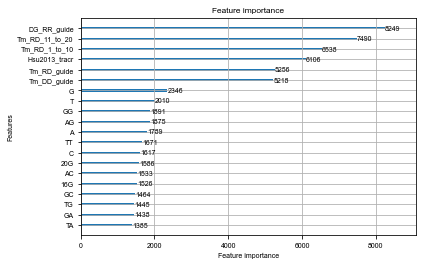

In [9]:
plot_importance(model, max_num_features=20)

In [10]:
explainer = shap.TreeExplainer(model)

In [11]:
%%time
shap_values = explainer.shap_values(X_train)

CPU times: user 2h 17min 50s, sys: 26.6 s, total: 2h 18min 17s
Wall time: 17min 43s


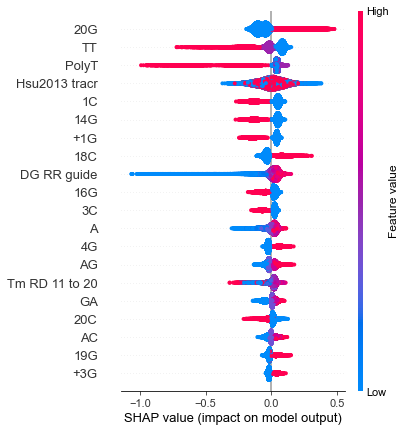

In [12]:
shap.summary_plot(shap_values, X_train, show=False, plot_size=(5, 7))
gpplot.savefig('../figures/seq_shap_summary_plot.pdf', dpi=300)

In [13]:
shap_df = pd.DataFrame(shap_values, columns=X_train.columns)
shap_abs_importance = (shap_df.abs().mean(0)
                       .reset_index()
                       .rename({0: 'importance',
                                'index': 'feature'}, axis=1)
                       .sort_values('importance', ascending=False))
top_n = 20
top_features = shap_abs_importance.head(top_n).copy()
top_features['feature'] = pd.Categorical(top_features['feature'], categories=top_features['feature'])

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 2.2 x 2.4 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/seq_shap_feature_importance.pdf


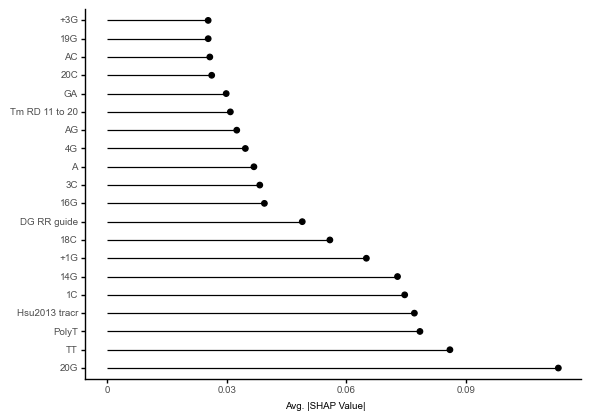

<ggplot: (8779656849396)>

In [14]:
g = lollipop_plot(top_features, 'feature', 'importance', xlabel='Avg. |SHAP Value|', ylabel='')
g.save('../figures/seq_shap_feature_importance.pdf', width=2.2, height=2.4)
g

In [41]:
shap_abs_importance[shap_abs_importance['feature'].str.contains('tracr')]

,feature,importance
630,Hsu2013 tracr,0.077138
631,Chen2013 tracr,0.000312


/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


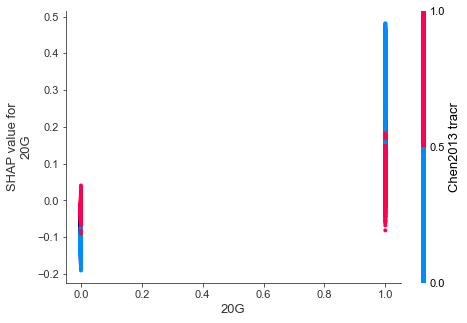

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


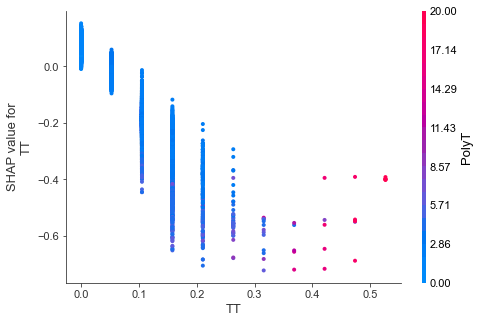

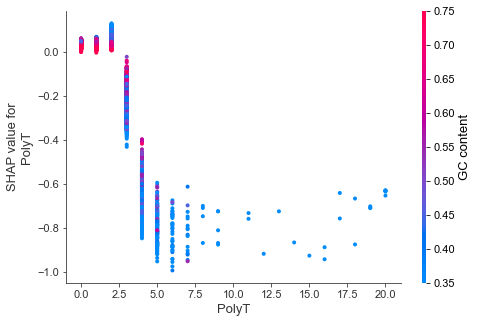

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


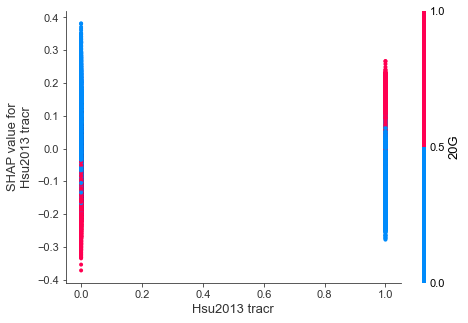

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


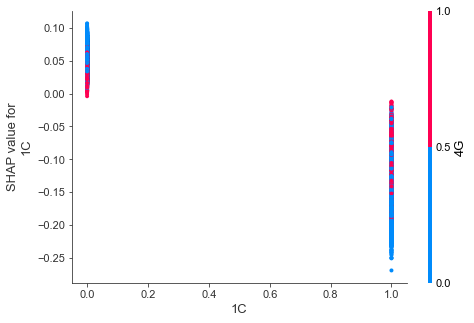

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


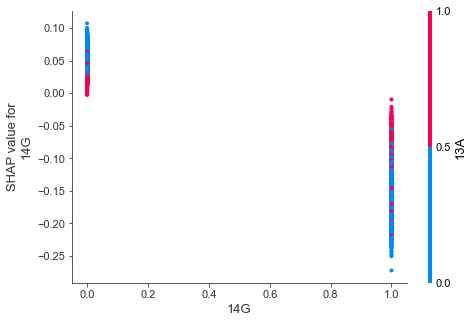

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


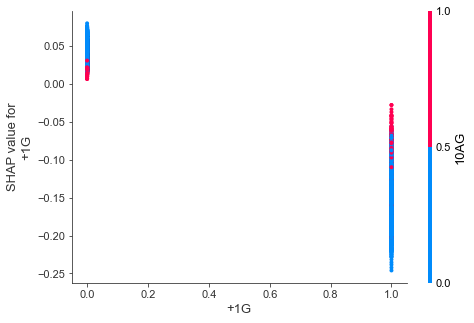

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


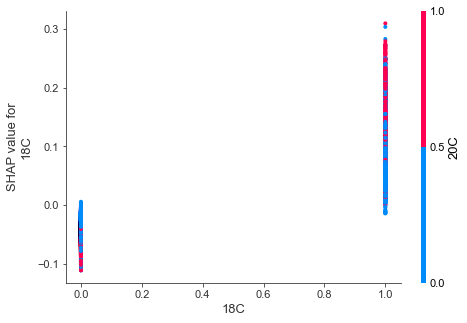

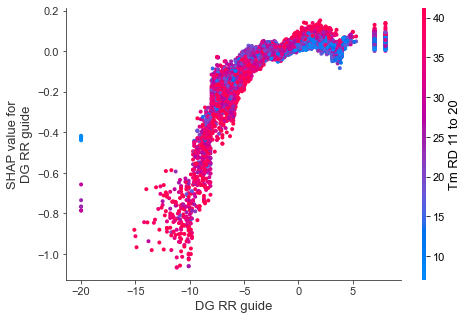

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


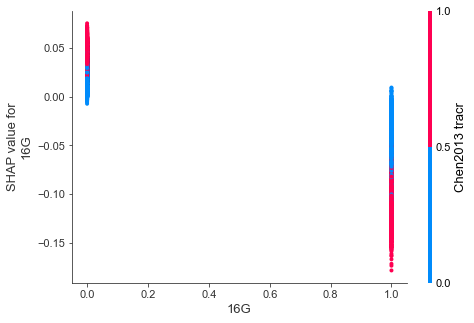

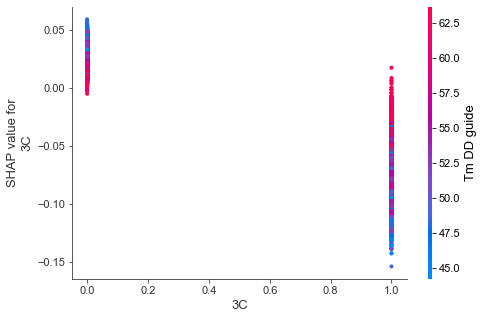

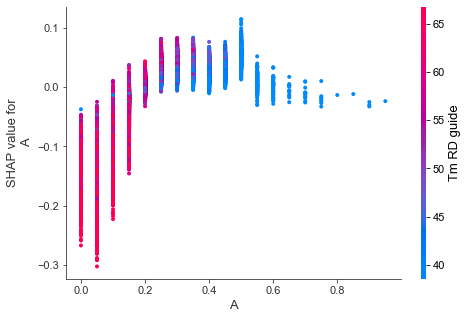

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


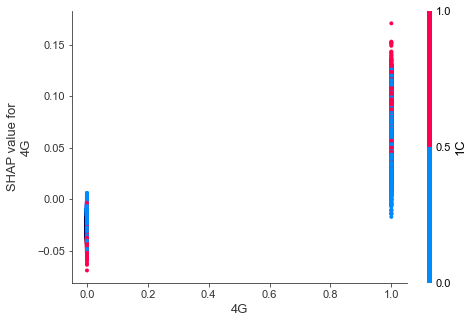

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


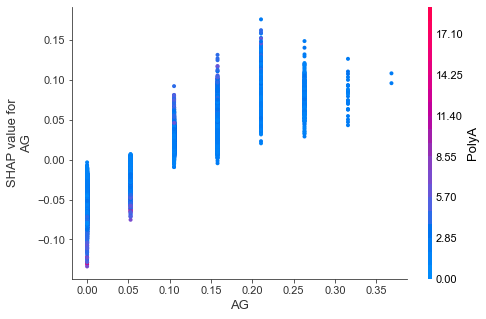

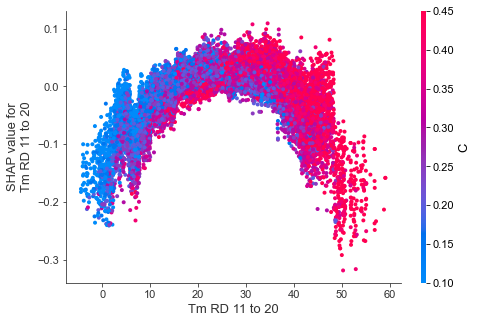

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


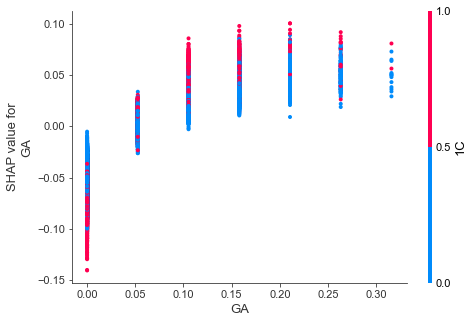

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


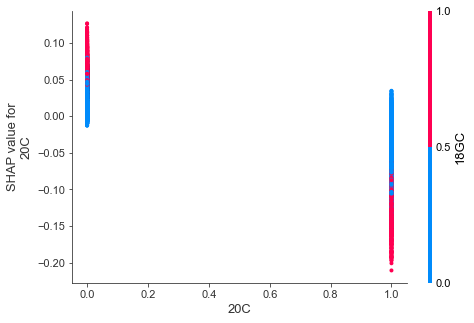

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


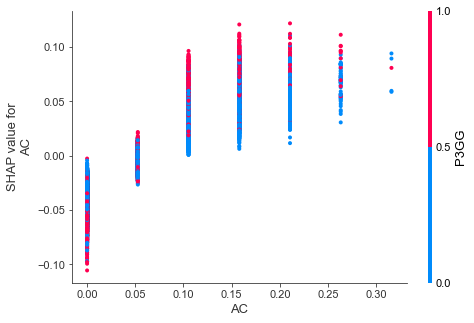

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


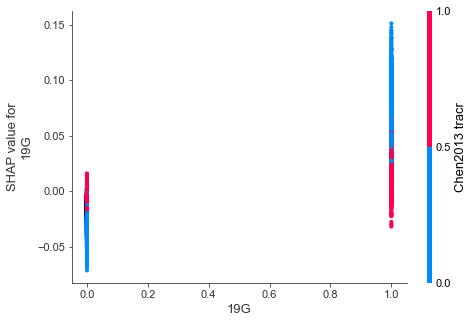

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


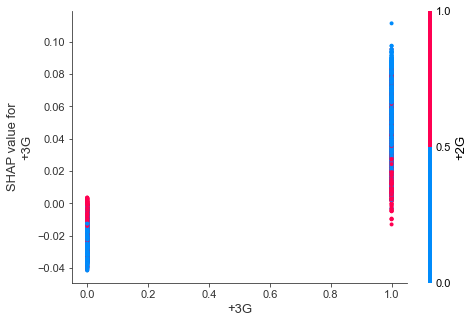

In [19]:
for feature in top_features['feature']:
    shap.dependence_plot(feature, shap_values, X_train)

In [24]:
interesting_features = ['20G', '20C', 'PolyT', 'Hsu2013 tracr', 'Chen2013 tracr', 'DG RR guide',
                        'Tm RD 11 to 20', 'GC content']

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


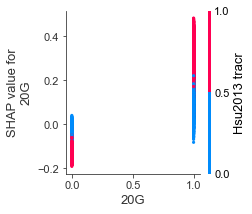

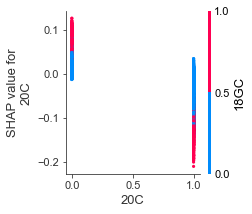

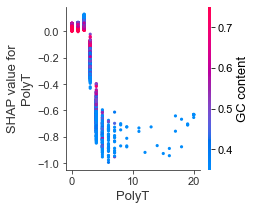

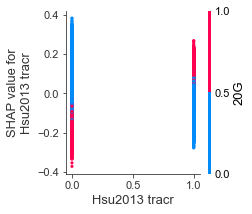

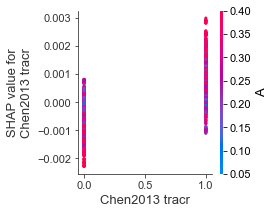

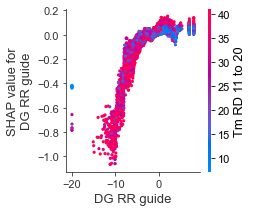

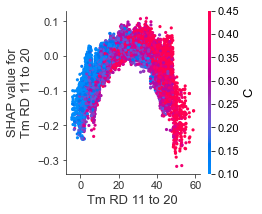

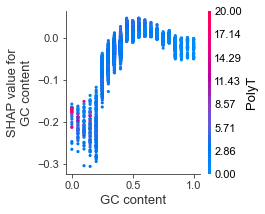

In [25]:
for ft in interesting_features:
    shap.dependence_plot(ft, shap_values, X_train, show=False, dot_size=10)
    fig = plt.gcf()
    fig.set_figheight(3)
    fig.set_figwidth(3)
    gpplot.savefig('../figures/seq_shap_' + ft + '_plot.pdf', dpi=300)

## Tracr interactions

In [36]:
hsu_interaction_index = shap.approximate_interactions('Hsu2013 tracr', shap_values,
                                                      X_train)
hsu_interaction_features = X_train.columns[hsu_interaction_index]
hsu_interaction_features

Index(['20G', '20T', 'GC content', 'G', 'Tm DD guide', '20GA', '19CG', '19GG',
       'T', '20GT',
       ...
       'P3T', 'P2GA', 'P2TG', 'P2TT', 'P2TC', 'P2TA', 'P2CG', 'P2CT', 'P2CA',
       'P2GC'],
      dtype='object', length=632)

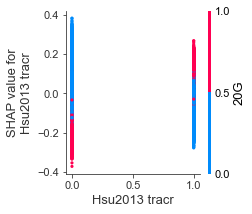

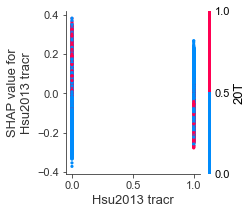

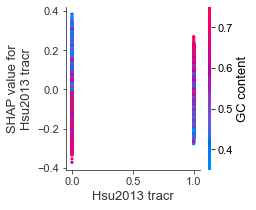

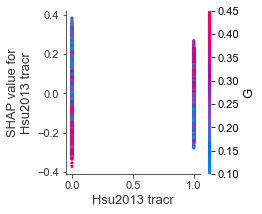

In [39]:
for pair in hsu_interaction_features[:4]:
    shap.dependence_plot('Hsu2013 tracr', shap_values, X_train, show=False, dot_size=10,
                         interaction_index=pair)
    fig = plt.gcf()
    fig.set_figheight(3)
    fig.set_figwidth(3)

In [33]:
chen_interaction_index = shap.approximate_interactions('Chen2013 tracr', shap_values,
                                                       X_train)
chen_interaction_features = X_train.columns[chen_interaction_index]
chen_interaction_features

Index(['A', 'Tm RD guide', 'GC content', 'Tm DD guide', 'Tm RD 11 to 20', 'AA',
       'P3GG', '+1G', 'PolyA', '18T',
       ...
       'P2GG', 'P2GT', 'P2GC', 'P2GA', 'P2TG', 'P2TT', 'P2TC', 'P2TA', 'P3TT',
       'Chen2013 tracr'],
      dtype='object', length=632)

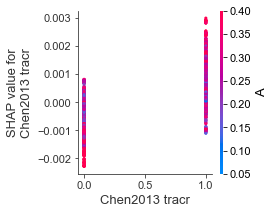

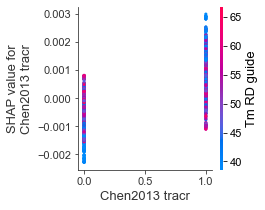

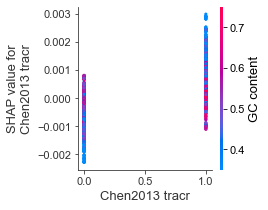

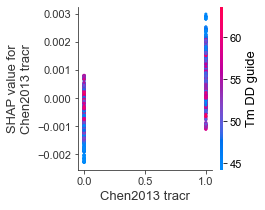

In [40]:
for pair in chen_interaction_features[:4]:
    shap.dependence_plot('Chen2013 tracr', shap_values, X_train, show=False, dot_size=10,
                         interaction_index=pair)
    fig = plt.gcf()
    fig.set_figheight(3)
    fig.set_figwidth(3)

## Output Model

In [26]:
joblib.dump(model, '../models/RuleSet3.pkl')

['../models/RuleSet3.pkl']